In [ ]:
import sys

!{sys.executable} -m pip install librosa seaborn

In [26]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Data Preparation

In [27]:
npz_data = np.load('../../data/48k_data/training.npz')
meta_data = json.load(open("../../data/48k_data/meta.json", 'r'))

In [ ]:
id2label = {v:k for k,v in meta_data['labels'].items()}
id2label

In [29]:
S = [librosa.feature.melspectrogram(
        y=x,
        sr=meta_data["sample_rate"],
        power=1) 
     for x in npz_data['X']]

In [30]:
S_db = [librosa.power_to_db(item, ref=np.max) for item in S]

In [31]:
S_db_flattened = [item.flatten() for item in S_db]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(S_db_flattened, npz_data['y'], test_size=0.2, random_state=42)

# Pipeline

In [33]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [34]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('classifier', model) 
])

In [ ]:
pipeline.fit(X_train, y_train)

# Evaluation

In [36]:
y_pred = pipeline.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.63      0.72      0.67        57
           2       0.77      0.84      0.80        75
           3       0.60      0.64      0.62        14
           4       0.29      0.10      0.14        21

    accuracy                           0.69       182
   macro avg       0.61      0.59      0.59       182
weighted avg       0.66      0.69      0.66       182



In [38]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

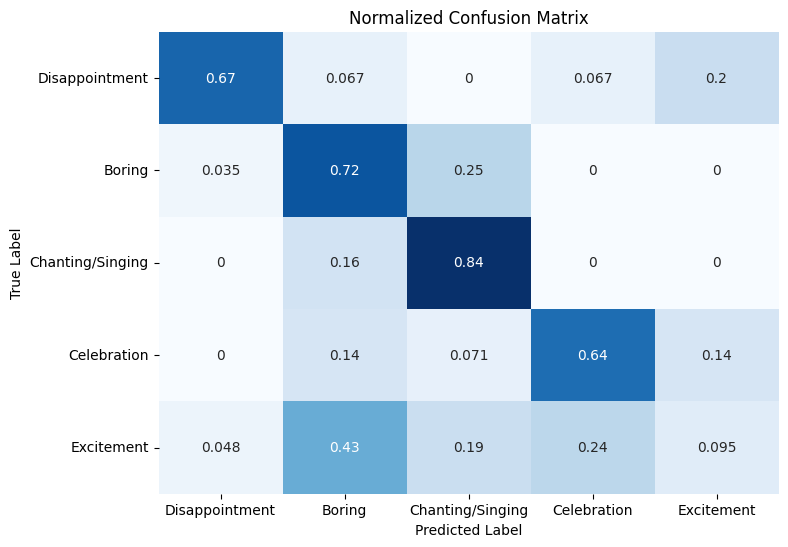

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()